# Experimentación modelo predictivo

## Imports

Primero, se importan las dependencias necesarias para la experimentación. Principalmente se trabajará con tensorflow, para calcular metricas, y keras para construir redes neuronales, instanciar redes ya existentes, crear generadores de datos, realizar data augmentatión.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from keras import regularizers, initializers, Model, optimizers
from keras.applications import VGG16, VGG19, ResNet50, InceptionV3
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Input, concatenate
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint
from keras.utils import multi_gpu_model

Using TensorFlow backend.


# Entrenamiento desde cero

### Definición de función de entrenamiento

A continuación se define la función con  que se entrenará los diferentes modelos. Se compila con metricas de exactitud para comparar los resultados de los diferentes modelos. Se realiza data augmentatión y se entrena el modelo. La función para entrenar recibe el modelo que debe entrenar, define los generadores de datos, compila el modelo, entrena y, finalmente, retorna la historia del entrenamiento.

**Nota:** fue necesario instanciar el optimizador (adam) con parametros diferentes a los predeterminados dado que la exactitud de entrenamiento se mantenia en la linea base (76.2%).

In [5]:
# model: model to be trained
# dataset: leishmaniasis, melanoma_novus, cats_and_dogs
# epochs: number of ephocs for training
# save_as: name to save best weigths
def train_model(model,dataset,epochs,image_size=224,batch_size=64,save_as='no_save'):
    # Data generator to  rescale training images
    # Data Augmentation: Horizontal and vertical flips
    train_datagen = ImageDataGenerator(rescale=1./255.0,
                                      vertical_flip=True,
                                      horizontal_flip=True)
    # Data generator to rescale test images
    test_datagen = ImageDataGenerator(rescale=1./255.0)
    # Data flow training images
    train_flow = train_datagen.flow_from_directory(
        directory='src/'+dataset+'/training',  
        target_size=(image_size, image_size),  
        batch_size=batch_size,
        class_mode='binary')
    # Data flow test images
    test_flow = test_datagen.flow_from_directory(
        directory='src/'+dataset+'/test',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary')
    # Compile model
    adam = optimizers.Adam(lr=0.001,
                          beta_1=0.9,
                          beta_2=0.999,
                          epsilon=None,
                          decay=0.0,
                          amsgrad=False)
    model.compile(
        loss='binary_crossentropy',
        optimizer=adam,
        metrics=['acc'])
    # Check if wegths are gona be saved
    if( save_as != 'no_save'):
        # Create check point call back to store best validation weigths
        bestWeigthsPath='src/trainingWeigths/best_' + save_as+'.hdf5'
        checkpoint = ModelCheckpoint(bestWeigthsPath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        # Run experiment
        history = model.fit_generator(
            generator=train_flow,
            epochs=epochs,
            validation_data=test_flow,
            callbacks=[checkpoint],
            verbose=1)
    else:
        # Run experiment
        history = model.fit_generator(
            generator=train_flow,
            epochs=epochs,
            validation_data=test_flow,
            verbose=1)
    return history

### Definición funcion para exportar modelo

Para la posterior integración del modelo con una herramienta movil se exportará el modelo en formato .hdf5. Anteriormente, creamos un checkpoint que cumple con esta función; sin embargo, solo se exporta los pesos del modelo y no el modelo completo (pesos + estructura). Teniendo en cuenta lo anterior es necesario cargar los pesos de los mejores resultados de entrenamiento (CheckPoint), y luego exportar el modelo entero (pesos + estructura).

In [2]:
def export(model,save_as):
    # Load checkpoint weigths
    model.load_weights('src/trainingWeigths/best_' + save_as+ '.hdf5')
    # Remove file
    os.remove('src/trainingWeigths/best_' + save_as+ '.hdf5')
    # Create new file saving model and weigths
    model.save('src/trainingWeigths/best_' + save_as+ '.h5')

### Definición función para visualizar resultados

Despues de entrenar cada modelo, se mostrara una grafica en donde se visualiza la exactitud tanto para el entrenamiento como la la validación en las diferentes epocas. Esto nos permitirá observare en que punto se llega o overfitting, y cual es el comportamiento general en este aspecto.

In [2]:
def get_plt(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    return plt

### Cración de modelo predictivo

Se define una red neuronal con operaciones de convolucion y pooling, seguidas de capas de clasificación (Flatten, dense). 

In [9]:
# Load custom model
def build_CNN_model(image_size=224):
    #Input
    inputs = Input(shape=(image_size,image_size,3,))
    #BranchOne
    model = Conv2D(filters=16,kernel_size=(3,3),activation='relu')(inputs)
    model = Conv2D(filters=32,kernel_size=(3,3),activation='relu')(model)
    model = MaxPooling2D(pool_size=(2,2))(model)    
    model = Conv2D(filters=64,kernel_size=(3,3),activation='relu')(model) 
    model = Conv2D(filters=128,kernel_size=(3,3),activation='relu')(model)
    model = MaxPooling2D(pool_size=(2,2))(model)
    model = Flatten()(model)
    model = Dense(124,activation='relu')(model)
    model = Dropout(0.5)(model)
    #Output
    out = Dense(1, activation='sigmoid')(model)
    # Compile Model
    model = Model(inputs=[inputs], outputs=[out])
    model.summary()
    model = multi_gpu_model(model, gpus=2)
    return model

### Perros y gatos para probar modelo


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 106, 106, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 53, 53, 128)       0         
__________

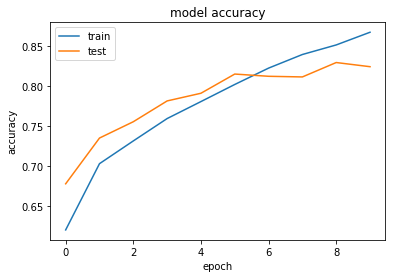

In [6]:
model = build_CNN_model()
history = train_model(model,'dogs_and_cats',10)
plt = get_plt(history)
plt.show()

La linea base para perros y gatos es del 50%, ya que se tienen la misma cantidad de imagenes para las dos clases. Los dataset de entrenamiento y prueba se encuentran estratificados.

Sobre el dataset de perros y gatos, en 10 epocas, se logra superar la linea base y alcanzar un accuracy de validación de 82,92%.

### Entrenar modelo con dataset de Leishmaniasis Cutanea

Despues de probar el modelo con perros y gatos se probará con leishmaniasis cutanea, para ver como desempeña y establecer un punto incial para resolver el problema. Cabe destacar que el tamaño de los datasets es diferente. El dataset de perros y gatos tiene 21500 de imagenes de entrenamiento, el de lishmaniasis cutanea tiene 1640 y está desbalanceado.

La linea base, dado el número de imagenes negativas y positivas, es del 76%. Si el modelo predice que todas son leishmaniasis, se obtendrá accuracy de 76%.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 220, 220, 32)      4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 106, 106, 128)     73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 53, 53, 128)       0         
__________

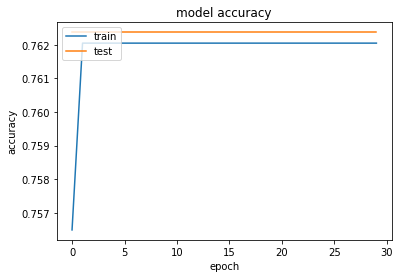

In [7]:
model = build_CNN_model()
history = train_model(model,'leishmaniasis',30)
plt = get_plt(history)
plt.show()

Del entrenamiento anterior se observa que no fue posible superar la linea base, tanto para el entrenamiento como para la validación. Esto presenta problemas dado que el accuracy de entrenamiento deberia de incrementar y ajustarse totalmente a los datos de entrenamiento, generado un estado de overfitting. 

Se procede a redefinir la función de entrenamiento con el fin de conseguir que el modelo aprenda correctamente las caracteristicas del conjunto de entrenamiento, y entré en overfitting. 

In [3]:
# model: model to be trained
# dataset: leishmaniasis, melanoma_novus, cats_and_dogs
# epochs: number of ephocs for training
# save_as: name to save best weigths
def train_model(model,dataset,epochs,image_size=224,batch_size=64,save_as='no_save'):
    # Data generator to  rescale training images
    # Data Augmentation: Horizontal and vertical flips
    train_datagen = ImageDataGenerator(rescale=1./255.0,
                                      vertical_flip=True,
                                      horizontal_flip=True)
    # Data generator to rescale test images
    test_datagen = ImageDataGenerator(rescale=1./255.0)
    # Data flow training images
    train_flow = train_datagen.flow_from_directory(
        directory='src/'+dataset+'/training',  
        target_size=(image_size, image_size),  
        batch_size=batch_size,
        class_mode='binary')
    # Data flow test images
    test_flow = test_datagen.flow_from_directory(
        directory='src/'+dataset+'/test',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary')
    # Compile model
    adam = optimizers.Adam(lr=0.0001,
                          beta_1=0.9,
                          beta_2=0.999,
                          epsilon=None,
                          decay=0.00001,
                          amsgrad=False)
    model.compile(
        loss='binary_crossentropy',
        optimizer=adam,
        metrics=['acc'])
    # Check if wegths are gona be saved
    if( save_as != 'no_save'):
        # Create check point call back to store best validation weigths
        bestWeigthsPath='src/trainingWeigths/best_' + save_as+'.h5'
        checkpoint = ModelCheckpoint(bestWeigthsPath, monitor='val_acc',save_weights_only=False, verbose=1, save_best_only=True, mode='max')
        # Run experiment
        history = model.fit_generator(
            generator=train_flow,
            epochs=epochs,
            validation_data=test_flow,
            callbacks=[checkpoint],
            verbose=1)
    else:
        # Run experiment
        history = model.fit_generator(
            generator=train_flow,
            epochs=epochs,
            validation_data=test_flow,
            verbose=1)
    return history

Se cambió el optimizador. Se utilizó un learning rate 10 veces menor que el utilizado en el problema de perros y gatos. Además, se definió decay= 0.00001, por lo que el learning rate disminuye a medida que corren las epocas. Se optó por esta decisión dado que es posible que al tener un learning rate alto, sin decay, no sea posible llegar a un minimo local, sino que se tienen saltos grandes.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 220, 220, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 106, 106, 128)     73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 53, 53, 128)       0         
__________

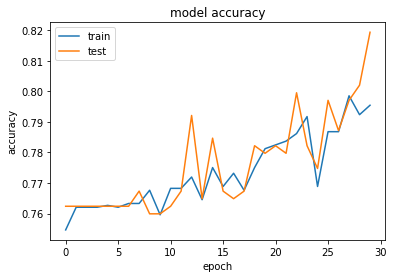

In [10]:
model = build_CNN_model()
history = train_model(model,'leishmaniasis',30)
plt = get_plt(history)
plt.show()

Comprobamos que al cambiar el learning rate es posible salir de la linea base, ahora se correran 100 épocas, con el fin de ver en que momento se entra en overfitting, y que valor máximo de accuracy de validación se puede obtener.

### primer intento

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 220, 220, 32)      4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 106, 106, 128)     73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 53, 53, 128)       0         
__________

26/26 [==============================] - 31s 1s/step - loss: 0.2047 - acc: 0.9063 - val_loss: 0.5716 - val_acc: 0.7921

Epoch 00077: val_acc did not improve from 0.80693
Epoch 78/150
26/26 [==============================] - 31s 1s/step - loss: 0.1825 - acc: 0.9168 - val_loss: 0.6707 - val_acc: 0.7871

Epoch 00078: val_acc did not improve from 0.80693
Epoch 79/150
26/26 [==============================] - 31s 1s/step - loss: 0.1781 - acc: 0.9152 - val_loss: 0.6301 - val_acc: 0.7921

Epoch 00079: val_acc did not improve from 0.80693
Epoch 80/150
26/26 [==============================] - 31s 1s/step - loss: 0.1757 - acc: 0.9170 - val_loss: 0.6000 - val_acc: 0.7847

Epoch 00080: val_acc did not improve from 0.80693
Epoch 81/150
26/26 [==============================] - 32s 1s/step - loss: 0.1780 - acc: 0.9110 - val_loss: 0.5639 - val_acc: 0.8020

Epoch 00081: val_acc did not improve from 0.80693
Epoch 82/150
26/26 [==============================] - 31s 1s/step - loss: 0.1806 - acc: 0.9131 - v


Epoch 00121: val_acc did not improve from 0.80693
Epoch 122/150
26/26 [==============================] - 31s 1s/step - loss: 0.0970 - acc: 0.9570 - val_loss: 0.8132 - val_acc: 0.7822

Epoch 00122: val_acc did not improve from 0.80693
Epoch 123/150
26/26 [==============================] - 30s 1s/step - loss: 0.0912 - acc: 0.9567 - val_loss: 0.8340 - val_acc: 0.7896

Epoch 00123: val_acc did not improve from 0.80693
Epoch 124/150
26/26 [==============================] - 31s 1s/step - loss: 0.0903 - acc: 0.9639 - val_loss: 0.8985 - val_acc: 0.7896

Epoch 00124: val_acc did not improve from 0.80693
Epoch 125/150
26/26 [==============================] - 32s 1s/step - loss: 0.0920 - acc: 0.9640 - val_loss: 0.8120 - val_acc: 0.7946

Epoch 00125: val_acc did not improve from 0.80693
Epoch 126/150
26/26 [==============================] - 32s 1s/step - loss: 0.1158 - acc: 0.9501 - val_loss: 0.8421 - val_acc: 0.7871

Epoch 00126: val_acc did not improve from 0.80693
Epoch 127/150
26/26 [========

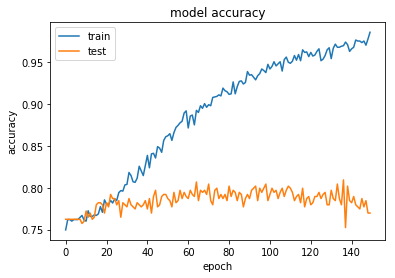

In [21]:
model = build_CNN_model()
history = train_model(model,'leishmaniasis',150,save_as='first_try')
export(model,'first_try')
plt = get_plt(history)
plt.show()

De lo anterior se observa que la máxima exactitud que se obtuvo es de 80.9%. Tambien se observa que el modelo entra en sobre ajuste. Al entrar en sobre ajuste, las caracteristicas que guarda el modelo pueden estar demasiado ajustadas al conjunto de entrenamiento. 

### Regularización de kernel y bias

Para combatir el sobre ajuste,  se agregará regularización l2 de kernel y bias, y se agrega una capa extra de dropout. Se procede a ejecutar 150 epocas para ver si esta medida es efectiva.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 220, 220, 32)      4640      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 106, 106, 128)     73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 53, 53, 128)       0         
__________

26/26 [==============================] - 30s 1s/step - loss: 0.6287 - acc: 0.8087 - val_loss: 0.7216 - val_acc: 0.7748

Epoch 00076: val_acc did not improve from 0.79208
Epoch 77/150
26/26 [==============================] - 31s 1s/step - loss: 0.6230 - acc: 0.8115 - val_loss: 0.7236 - val_acc: 0.7772

Epoch 00077: val_acc did not improve from 0.79208
Epoch 78/150
26/26 [==============================] - 30s 1s/step - loss: 0.6149 - acc: 0.8075 - val_loss: 0.7406 - val_acc: 0.7822

Epoch 00078: val_acc did not improve from 0.79208
Epoch 79/150
26/26 [==============================] - 30s 1s/step - loss: 0.6053 - acc: 0.8151 - val_loss: 0.7489 - val_acc: 0.7797

Epoch 00079: val_acc did not improve from 0.79208
Epoch 80/150
26/26 [==============================] - 31s 1s/step - loss: 0.6070 - acc: 0.8140 - val_loss: 0.7174 - val_acc: 0.7772

Epoch 00080: val_acc did not improve from 0.79208
Epoch 81/150
26/26 [==============================] - 30s 1s/step - loss: 0.6096 - acc: 0.8050 - v

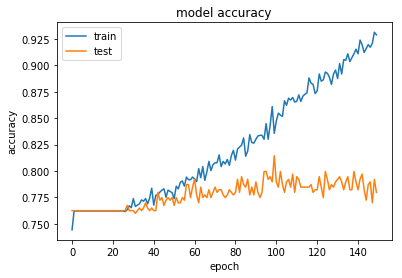

In [22]:
# Load custom model
def build_CNN_model(image_size=224):
    #Input
    inputs = Input(shape=(image_size,image_size,3,))
    #BranchOne
    model = Conv2D(filters=16,kernel_size=(3,3),activation='relu',
                   kernel_regularizer=regularizers.l2(0.01),bias_regularizer=regularizers.l2(0.01))(inputs)
    model = Conv2D(filters=32,kernel_size=(3,3),activation='relu',
                   kernel_regularizer=regularizers.l2(0.01),bias_regularizer=regularizers.l2(0.01))(model)
    model = MaxPooling2D(pool_size=(2,2))(model)    
    model = Conv2D(filters=64,kernel_size=(3,3),activation='relu',
                   kernel_regularizer=regularizers.l2(0.01),bias_regularizer=regularizers.l2(0.01))(model) 
    model = Conv2D(filters=128,kernel_size=(3,3),activation='relu',
                   kernel_regularizer=regularizers.l2(0.01),bias_regularizer=regularizers.l2(0.01))(model)
    model = MaxPooling2D(pool_size=(2,2))(model)
    model = Flatten()(model)
    model = Dropout(0.2)(model)
    model = Dense(124,activation='relu')(model)
    model = Dropout(0.5)(model)
    #Output
    out = Dense(1, activation='sigmoid')(model)
    # Compile Model
    model = Model(inputs=[inputs], outputs=[out])
    model.summary()
    model = multi_gpu_model(model, gpus=2)
    return model

model = build_CNN_model()
history = train_model(model,'leishmaniasis',150,save_as='second_try')
export(model,'second_try')
plt = get_plt(history)
plt.show()

# Transfer learning

### Definición de función para crear modelo

Primero, se crea una función que reciba capas convolucionales, las congele todas y agregue capas de clasificación al final. Se imprimirá la información de cada capa y se correrá en dos GPU.

In [14]:
# Builds model for transfer learning and fine tunning
def build_transfer_learning_model(conv_layers):
    # Freeze conv layers that are not going to be trained
    for layer in conv_layers.layers[:]:
        layer.trainable = False 
    # Print summary of the layers
    for layer in conv_layers.layers:
        print(layer, layer.trainable)    
    # Create sequential model
    model = Sequential()
    # add conv layers to model
    model.add(conv_layers)
    # Add clasification layers to model
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model = multi_gpu_model(model, gpus=2)
    model.summary()
    return model  

Se intentará realizar el entrenamiento con cuatro redes convolucionales creadas de keras applications. Se cargaran los pesos de image net. No se incluirá la parte de clasificación de estas redes.

### VGG16

In [26]:
image_size=224

58892288/58889256 [==============================] - 215s 4us/step
<keras.engine.input_layer.InputLayer object at 0x7efd7e8e7278> False
<keras.layers.convolutional.Conv2D object at 0x7efd84102f28> False
<keras.layers.convolutional.Conv2D object at 0x7efd7ed12780> False
<keras.layers.pooling.MaxPooling2D object at 0x7efd8415ed30> False
<keras.layers.convolutional.Conv2D object at 0x7efd7ed02438> False
<keras.layers.convolutional.Conv2D object at 0x7efd7e8a2550> False
<keras.layers.pooling.MaxPooling2D object at 0x7efd7e807860> False
<keras.layers.convolutional.Conv2D object at 0x7efd7e8167f0> False
<keras.layers.convolutional.Conv2D object at 0x7efd7e830978> False
<keras.layers.convolutional.Conv2D object at 0x7efd7dedab38> False
<keras.layers.pooling.MaxPooling2D object at 0x7efd7dec5d30> False
<keras.layers.convolutional.Conv2D object at 0x7efd7deef550> False
<keras.layers.convolutional.Conv2D object at 0x7efd7de9c358> False
<keras.layers.convolutional.Conv2D object at 0x7efd7de9cf98>

26/26 [==============================] - 30s 1s/step - loss: 0.1620 - acc: 0.9501 - val_loss: 0.3563 - val_acc: 0.8639

Epoch 00068: val_acc did not improve from 0.86881
Epoch 69/150
26/26 [==============================] - 30s 1s/step - loss: 0.1665 - acc: 0.9399 - val_loss: 0.3434 - val_acc: 0.8589

Epoch 00069: val_acc did not improve from 0.86881
Epoch 70/150
26/26 [==============================] - 31s 1s/step - loss: 0.1721 - acc: 0.9356 - val_loss: 0.4049 - val_acc: 0.8317

Epoch 00070: val_acc did not improve from 0.86881
Epoch 71/150
26/26 [==============================] - 31s 1s/step - loss: 0.1716 - acc: 0.9339 - val_loss: 0.3482 - val_acc: 0.8589

Epoch 00071: val_acc did not improve from 0.86881
Epoch 72/150
26/26 [==============================] - 30s 1s/step - loss: 0.1649 - acc: 0.9428 - val_loss: 0.3498 - val_acc: 0.8540

Epoch 00072: val_acc did not improve from 0.86881
Epoch 73/150
26/26 [==============================] - 31s 1s/step - loss: 0.1583 - acc: 0.9416 - v

26/26 [==============================] - 30s 1s/step - loss: 0.0980 - acc: 0.9714 - val_loss: 0.3809 - val_acc: 0.8639

Epoch 00112: val_acc did not improve from 0.87376
Epoch 113/150
26/26 [==============================] - 31s 1s/step - loss: 0.0968 - acc: 0.9684 - val_loss: 0.3404 - val_acc: 0.8713

Epoch 00113: val_acc did not improve from 0.87376
Epoch 114/150
26/26 [==============================] - 31s 1s/step - loss: 0.1100 - acc: 0.9654 - val_loss: 0.3797 - val_acc: 0.8614

Epoch 00114: val_acc did not improve from 0.87376
Epoch 115/150
26/26 [==============================] - 30s 1s/step - loss: 0.1080 - acc: 0.9639 - val_loss: 0.3427 - val_acc: 0.8688

Epoch 00115: val_acc did not improve from 0.87376
Epoch 116/150
26/26 [==============================] - 30s 1s/step - loss: 0.0927 - acc: 0.9769 - val_loss: 0.3537 - val_acc: 0.8589

Epoch 00116: val_acc did not improve from 0.87376
Epoch 117/150
26/26 [==============================] - 30s 1s/step - loss: 0.0910 - acc: 0.974

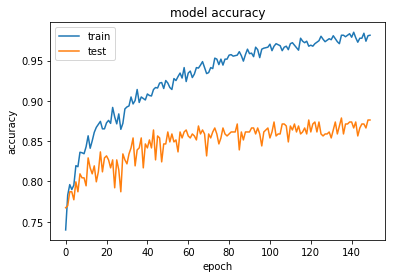

In [27]:
conv_layers = VGG16(weights='imagenet',include_top=False,input_shape=(image_size, image_size, 3))
model = build_transfer_learning_model(conv_layers)
history = train_model(model,'leishmaniasis',150,save_as='transfer_VGG16')
export(model, 'transfer_VGG16')
plt = get_plt(history)
plt.show()

### VGG19

80142336/80134624 [==============================] - 343s 4us/step
<keras.engine.input_layer.InputLayer object at 0x7efd7e8e63c8> False
<keras.layers.convolutional.Conv2D object at 0x7efd7cc23358> False
<keras.layers.convolutional.Conv2D object at 0x7efd8411f9e8> False
<keras.layers.pooling.MaxPooling2D object at 0x7efd7e8e7128> False
<keras.layers.convolutional.Conv2D object at 0x7efd7cbc7588> False
<keras.layers.convolutional.Conv2D object at 0x7efd7cbf6828> False
<keras.layers.pooling.MaxPooling2D object at 0x7efd7cb883c8> False
<keras.layers.convolutional.Conv2D object at 0x7efd7cb99710> False
<keras.layers.convolutional.Conv2D object at 0x7efd7cbb25f8> False
<keras.layers.convolutional.Conv2D object at 0x7efd7cb49e10> False
<keras.layers.convolutional.Conv2D object at 0x7efd7cb74828> False
<keras.layers.pooling.MaxPooling2D object at 0x7efd7cb02ef0> False
<keras.layers.convolutional.Conv2D object at 0x7efd7cb1ee48> False
<keras.layers.convolutional.Conv2D object at 0x7efd7cac9a20>

Epoch 25/150
26/26 [==============================] - 30s 1s/step - loss: 0.3214 - acc: 0.8626 - val_loss: 0.3836 - val_acc: 0.8465

Epoch 00025: val_acc improved from 0.84158 to 0.84653, saving model to src/trainingWeigths/best_transfer_VGG19.hdf5
Epoch 26/150
26/26 [==============================] - 31s 1s/step - loss: 0.3278 - acc: 0.8628 - val_loss: 0.3703 - val_acc: 0.8193

Epoch 00026: val_acc did not improve from 0.84653
Epoch 27/150
26/26 [==============================] - 31s 1s/step - loss: 0.3072 - acc: 0.8764 - val_loss: 0.3687 - val_acc: 0.8564

Epoch 00027: val_acc improved from 0.84653 to 0.85644, saving model to src/trainingWeigths/best_transfer_VGG19.hdf5
Epoch 28/150
26/26 [==============================] - 30s 1s/step - loss: 0.3042 - acc: 0.8773 - val_loss: 0.3776 - val_acc: 0.8168

Epoch 00028: val_acc did not improve from 0.85644
Epoch 29/150
26/26 [==============================] - 30s 1s/step - loss: 0.2975 - acc: 0.8671 - val_loss: 0.3674 - val_acc: 0.8540

Epo


Epoch 00067: val_acc did not improve from 0.86139
Epoch 68/150
26/26 [==============================] - 30s 1s/step - loss: 0.2167 - acc: 0.9158 - val_loss: 0.3593 - val_acc: 0.8564

Epoch 00068: val_acc did not improve from 0.86139
Epoch 69/150
26/26 [==============================] - 31s 1s/step - loss: 0.2106 - acc: 0.9224 - val_loss: 0.3624 - val_acc: 0.8663

Epoch 00069: val_acc improved from 0.86139 to 0.86634, saving model to src/trainingWeigths/best_transfer_VGG19.hdf5
Epoch 70/150
26/26 [==============================] - 30s 1s/step - loss: 0.2073 - acc: 0.9249 - val_loss: 0.3840 - val_acc: 0.8465

Epoch 00070: val_acc did not improve from 0.86634
Epoch 71/150
26/26 [==============================] - 30s 1s/step - loss: 0.2349 - acc: 0.9047 - val_loss: 0.3563 - val_acc: 0.8540

Epoch 00071: val_acc did not improve from 0.86634
Epoch 72/150
26/26 [==============================] - 30s 1s/step - loss: 0.2140 - acc: 0.9074 - val_loss: 0.4100 - val_acc: 0.8366

Epoch 00072: val_a

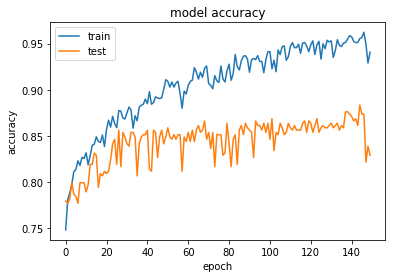

In [28]:
conv_layers = VGG19(weights='imagenet',include_top=False,input_shape=(image_size, image_size, 3))
model = build_transfer_learning_model(conv_layers)
history = train_model(model,'leishmaniasis',150,save_as='transfer_VGG19')
export(model, 'transfer_VGG19')
plt = get_plt(history)
plt.show()

### ResNet50

/home/icesi/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


<keras.engine.input_layer.InputLayer object at 0x7efd7efde940> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7efd7efdeba8> False
<keras.layers.convolutional.Conv2D object at 0x7efd7efdec88> False
<keras.layers.normalization.BatchNormalization object at 0x7efd840a2860> False
<keras.layers.core.Activation object at 0x7efd7efdedd8> False
<keras.layers.pooling.MaxPooling2D object at 0x7efd7ed81dd8> False
<keras.layers.convolutional.Conv2D object at 0x7efd5fd96c18> False
<keras.layers.normalization.BatchNormalization object at 0x7efd5fd479b0> False
<keras.layers.core.Activation object at 0x7efd5fd36cf8> False
<keras.layers.convolutional.Conv2D object at 0x7efd5fcd35f8> False
<keras.layers.normalization.BatchNormalization object at 0x7efd5fca4780> False
<keras.layers.core.Activation object at 0x7efd5fca4828> False
<keras.layers.convolutional.Conv2D object at 0x7efd5fbc34e0> False
<keras.layers.convolutional.Conv2D object at 0x7efd5fb976a0> False
<keras.layers.normalization.Batc

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
resnet50_input (InputLayer)     (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_21 (Lambda)              (None, 224, 224, 3)  0           resnet50_input[0][0]             
__________________________________________________________________________________________________
lambda_22 (Lambda)              (None, 224, 224, 3)  0           resnet50_input[0][0]             
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 1)            49278337    lambda_21[0][0]                  
                                                                 lambda_22[0][0]                  
__________

26/26 [==============================] - 30s 1s/step - loss: 0.0033 - acc: 1.0000 - val_loss: 1.3976 - val_acc: 0.7624

Epoch 00080: val_acc did not improve from 0.76238
Epoch 81/150
26/26 [==============================] - 29s 1s/step - loss: 0.0050 - acc: 0.9988 - val_loss: 1.2183 - val_acc: 0.7624

Epoch 00081: val_acc did not improve from 0.76238
Epoch 82/150
26/26 [==============================] - 30s 1s/step - loss: 0.0043 - acc: 0.9982 - val_loss: 1.4057 - val_acc: 0.7624

Epoch 00082: val_acc did not improve from 0.76238
Epoch 83/150
26/26 [==============================] - 30s 1s/step - loss: 0.0021 - acc: 1.0000 - val_loss: 1.5250 - val_acc: 0.7624

Epoch 00083: val_acc did not improve from 0.76238
Epoch 84/150
26/26 [==============================] - 30s 1s/step - loss: 0.0046 - acc: 0.9979 - val_loss: 1.3941 - val_acc: 0.7624

Epoch 00084: val_acc did not improve from 0.76238
Epoch 85/150
26/26 [==============================] - 30s 1s/step - loss: 0.0040 - acc: 0.9994 - v


Epoch 00124: val_acc did not improve from 0.76238
Epoch 125/150
26/26 [==============================] - 30s 1s/step - loss: 0.0162 - acc: 0.9937 - val_loss: 1.0146 - val_acc: 0.7624

Epoch 00125: val_acc did not improve from 0.76238
Epoch 126/150
26/26 [==============================] - 30s 1s/step - loss: 0.0067 - acc: 0.9988 - val_loss: 1.0075 - val_acc: 0.7624

Epoch 00126: val_acc did not improve from 0.76238
Epoch 127/150
26/26 [==============================] - 31s 1s/step - loss: 0.0035 - acc: 0.9994 - val_loss: 1.0625 - val_acc: 0.7624

Epoch 00127: val_acc did not improve from 0.76238
Epoch 128/150
26/26 [==============================] - 29s 1s/step - loss: 0.0020 - acc: 0.9994 - val_loss: 0.9288 - val_acc: 0.7624

Epoch 00128: val_acc did not improve from 0.76238
Epoch 129/150
26/26 [==============================] - 29s 1s/step - loss: 0.0132 - acc: 0.9952 - val_loss: 0.9969 - val_acc: 0.7624

Epoch 00129: val_acc did not improve from 0.76238
Epoch 130/150
26/26 [========

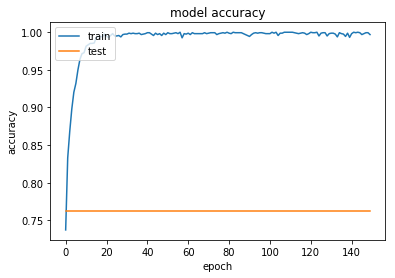

In [29]:
conv_layers = ResNet50(weights='imagenet',include_top=False,input_shape=(image_size, image_size, 3))
model = build_transfer_learning_model(conv_layers)
history = train_model(model,'leishmaniasis',150,save_as='transfer_ResNet50')
export(model, 'transfer_ResNet50')
plt = get_plt(history)
plt.show()

### InceptionV3

<keras.engine.input_layer.InputLayer object at 0x7f1106aff710> False
<keras.layers.convolutional.Conv2D object at 0x7f110b2146d8> False
<keras.layers.convolutional.Conv2D object at 0x7f1106aff048> False
<keras.layers.pooling.MaxPooling2D object at 0x7f110742b780> False
<keras.layers.convolutional.Conv2D object at 0x7f11073ea128> False
<keras.layers.convolutional.Conv2D object at 0x7f1106b59358> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1106b55278> False
<keras.layers.convolutional.Conv2D object at 0x7f1106b4a048> False
<keras.layers.convolutional.Conv2D object at 0x7f1107b61d68> False
<keras.layers.convolutional.Conv2D object at 0x7f1106ba36a0> False
<keras.layers.convolutional.Conv2D object at 0x7f1107e47be0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1107e4e8d0> False
<keras.layers.convolutional.Conv2D object at 0x7f1107e4b9b0> False
<keras.layers.convolutional.Conv2D object at 0x7f1106b31f28> False
<keras.layers.convolutional.Conv2D object at 0x7f1107327d68>

26/26 [==============================] - 33s 1s/step - loss: 0.4219 - acc: 0.8058 - val_loss: 0.4402 - val_acc: 0.7896

Epoch 00026: val_acc did not improve from 0.80941
Epoch 27/150
26/26 [==============================] - 34s 1s/step - loss: 0.4157 - acc: 0.8009 - val_loss: 0.4394 - val_acc: 0.7946

Epoch 00027: val_acc did not improve from 0.80941
Epoch 28/150
26/26 [==============================] - 33s 1s/step - loss: 0.4268 - acc: 0.7862 - val_loss: 0.4361 - val_acc: 0.7995

Epoch 00028: val_acc did not improve from 0.80941
Epoch 29/150
26/26 [==============================] - 33s 1s/step - loss: 0.4193 - acc: 0.8003 - val_loss: 0.4401 - val_acc: 0.7921

Epoch 00029: val_acc did not improve from 0.80941
Epoch 30/150
26/26 [==============================] - 34s 1s/step - loss: 0.4052 - acc: 0.8118 - val_loss: 0.4322 - val_acc: 0.7995

Epoch 00030: val_acc did not improve from 0.80941
Epoch 31/150
26/26 [==============================] - 33s 1s/step - loss: 0.4175 - acc: 0.7988 - v

26/26 [==============================] - 33s 1s/step - loss: 0.3611 - acc: 0.8382 - val_loss: 0.4404 - val_acc: 0.8045

Epoch 00113: val_acc did not improve from 0.83416
Epoch 114/150
26/26 [==============================] - 32s 1s/step - loss: 0.3701 - acc: 0.8162 - val_loss: 0.4328 - val_acc: 0.8094

Epoch 00114: val_acc did not improve from 0.83416
Epoch 115/150
26/26 [==============================] - 33s 1s/step - loss: 0.3479 - acc: 0.8427 - val_loss: 0.4254 - val_acc: 0.8069

Epoch 00115: val_acc did not improve from 0.83416
Epoch 116/150
26/26 [==============================] - 32s 1s/step - loss: 0.3503 - acc: 0.8347 - val_loss: 0.4336 - val_acc: 0.8168

Epoch 00116: val_acc did not improve from 0.83416
Epoch 117/150
26/26 [==============================] - 32s 1s/step - loss: 0.3498 - acc: 0.8389 - val_loss: 0.4227 - val_acc: 0.8144

Epoch 00117: val_acc did not improve from 0.83416
Epoch 118/150
26/26 [==============================] - 31s 1s/step - loss: 0.3585 - acc: 0.834

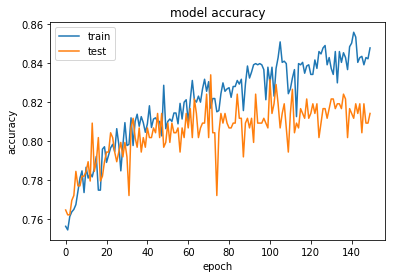

In [44]:
model = build_transfer_learning_model(conv_layers)
history = train_model(model,'leishmaniasis',150,save_as='transfer_InceptionV3')
plt = get_plt(history)
plt.show()

# Fine Tuning

A continuación se intentará realizar fine tuning con VGG19, que fue la red que mejor desempeñó en la predicción. Para esto se defina la función de construcción de modelo de fine tuning, congelando todas las capas menos las ultimas 5 (4 capas convolucionales).

In [4]:
# Builds model for transfer learning and fine tunning
def build_fine_tuning_model(conv_layers):
    # Freeze conv layers that are not going to be trained
    for layer in conv_layers.layers[:-5]:
        layer.trainable = False 
    # Print summary of the layers
    for layer in conv_layers.layers:
        print(layer, layer.trainable)    
    # Create sequential model
    model = Sequential()
    # add conv layers to model
    model.add(conv_layers)
    # Add clasification layers to model
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model = multi_gpu_model(model, gpus=2)
    model.summary()
    return model  

### Exportar historia

A partir de este punto se exportan las historias para su analisis.

In [5]:
def export_history(history, save_as,epochs):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    file = open('src/history/history' + save_as+'.txt','w')
    file.write('acc,val_acc'+'\n')
    for i in range(epochs):
        file.write(str(acc[i])+','+str(val_acc[i])+'\n')
    file.close() 

### VGG19

<keras.engine.input_layer.InputLayer object at 0x7f10fcdac3c8> False
<keras.layers.convolutional.Conv2D object at 0x7f10fcdac1d0> False
<keras.layers.convolutional.Conv2D object at 0x7f10fde56d68> False
<keras.layers.pooling.MaxPooling2D object at 0x7f10fd61b6a0> False
<keras.layers.convolutional.Conv2D object at 0x7f10fddde7b8> False
<keras.layers.convolutional.Conv2D object at 0x7f10fcd43f60> False
<keras.layers.pooling.MaxPooling2D object at 0x7f10fd5c1e10> False
<keras.layers.convolutional.Conv2D object at 0x7f10fd5d6da0> False
<keras.layers.convolutional.Conv2D object at 0x7f10fd5fb518> False
<keras.layers.convolutional.Conv2D object at 0x7f10fd5954a8> False
<keras.layers.convolutional.Conv2D object at 0x7f10fd5a9e80> False
<keras.layers.pooling.MaxPooling2D object at 0x7f10fd554898> False
<keras.layers.convolutional.Conv2D object at 0x7f10fd565828> False
<keras.layers.convolutional.Conv2D object at 0x7f10fd57d940> False
<keras.layers.convolutional.Conv2D object at 0x7f10fd516f28>

26/26 [==============================] - 32s 1s/step - loss: 0.0096 - acc: 0.9946 - val_loss: 0.5354 - val_acc: 0.9257

Epoch 00067: val_acc improved from 0.91584 to 0.92574, saving model to src/trainingWeigths/best_fine_tuning_VGG19.h5
Epoch 68/150
26/26 [==============================] - 31s 1s/step - loss: 0.0097 - acc: 0.9952 - val_loss: 0.6772 - val_acc: 0.9233

Epoch 00068: val_acc did not improve from 0.92574
Epoch 69/150
26/26 [==============================] - 31s 1s/step - loss: 0.0116 - acc: 0.9970 - val_loss: 0.7272 - val_acc: 0.8886

Epoch 00069: val_acc did not improve from 0.92574
Epoch 70/150
26/26 [==============================] - 32s 1s/step - loss: 0.0233 - acc: 0.9892 - val_loss: 0.4599 - val_acc: 0.9134

Epoch 00070: val_acc did not improve from 0.92574
Epoch 71/150
26/26 [==============================] - 32s 1s/step - loss: 0.0121 - acc: 0.9940 - val_loss: 0.7607 - val_acc: 0.8886

Epoch 00071: val_acc did not improve from 0.92574
Epoch 72/150
26/26 [===========

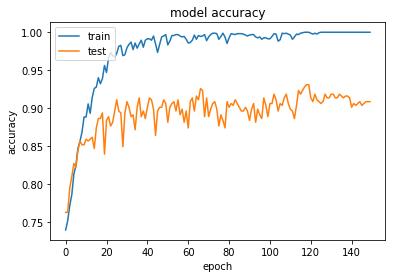

In [47]:
epochs = 150
save_as = 'fine_tuning_VGG19'
# Train model
conv_layers = VGG19(weights='imagenet',include_top=False,input_shape=(224, 224, 3))
model = build_fine_tuning_model(conv_layers)
history = train_model(model,'leishmaniasis',epochs,save_as=save_as)
# Export history
export_history(history, save_as,epochs)
# Plot accuracy
plt = get_plt(history)
plt.show()

### VGG19 functional API

In [28]:
# Builds model for transfer learning and fine tunning
def build_VGG19_fine_tuning_model():
    input_tensor = Input(shape=(224,224,3))
    conv_layers = VGG19(weights='imagenet',include_top=False,input_shape=(224, 224, 3),input_tensor=input_tensor)
    # Freeze conv layers that are not going to be trained
    for layer in conv_layers.layers[:-5]:
        layer.trainable = False 
    # Print summary of the layers
    for layer in conv_layers.layers:
        print(layer, layer.trainable)    
    # clasification layers
    top_model = Flatten()(conv_layers.output)
    top_model = Dense(256,activation='relu')(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(1,activation='sigmoid')(top_model)
    # create model
    model = Model(input=input_tensor, output=top_model)
    model = multi_gpu_model(model, gpus=2)
    model.summary()
    return model  

<keras.engine.input_layer.InputLayer object at 0x7f38ef676dd8> False
<keras.layers.convolutional.Conv2D object at 0x7f38ef676ac8> False
<keras.layers.convolutional.Conv2D object at 0x7f38ef6ac080> False
<keras.layers.pooling.MaxPooling2D object at 0x7f38ef6acb00> False
<keras.layers.convolutional.Conv2D object at 0x7f38ef69fa90> False
<keras.layers.convolutional.Conv2D object at 0x7f38ef59d160> False
<keras.layers.pooling.MaxPooling2D object at 0x7f38ef59de80> False
<keras.layers.convolutional.Conv2D object at 0x7f38ef5b1ac8> False
<keras.layers.convolutional.Conv2D object at 0x7f38ef5578d0> False
<keras.layers.convolutional.Conv2D object at 0x7f38ef56a860> False
<keras.layers.convolutional.Conv2D object at 0x7f38ef57cf28> False
<keras.layers.pooling.MaxPooling2D object at 0x7f38ef529c50> False
<keras.layers.convolutional.Conv2D object at 0x7f38ef539be0> False
<keras.layers.convolutional.Conv2D object at 0x7f38ef4de438> False
<keras.layers.convolutional.Conv2D object at 0x7f38ef4def98>

/home/icesi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 224, 224, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 224, 224, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
model_6 (Model)                 (None, 1)            26447425    lambda_5[0][0]                   
                                                                 lambda_6[0][0]                   
__________

26/26 [==============================] - 33s 1s/step - loss: 0.0488 - acc: 0.9807 - val_loss: 0.4951 - val_acc: 0.8985

Epoch 00033: val_acc did not improve from 0.90842
Epoch 34/150
26/26 [==============================] - 35s 1s/step - loss: 0.0291 - acc: 0.9898 - val_loss: 0.5074 - val_acc: 0.9010

Epoch 00034: val_acc did not improve from 0.90842
Epoch 35/150
26/26 [==============================] - 33s 1s/step - loss: 0.0457 - acc: 0.9832 - val_loss: 0.4840 - val_acc: 0.8936

Epoch 00035: val_acc did not improve from 0.90842
Epoch 36/150
26/26 [==============================] - 34s 1s/step - loss: 0.0503 - acc: 0.9772 - val_loss: 0.8504 - val_acc: 0.8713

Epoch 00036: val_acc did not improve from 0.90842
Epoch 37/150
26/26 [==============================] - 33s 1s/step - loss: 0.0731 - acc: 0.9700 - val_loss: 0.4053 - val_acc: 0.9109

Epoch 00037: val_acc improved from 0.90842 to 0.91089, saving model to src/trainingWeigths/best_fine_tuning_VGG19_2.h5
Epoch 38/150
26/26 [=========

26/26 [==============================] - 33s 1s/step - loss: 0.0147 - acc: 0.9946 - val_loss: 0.6094 - val_acc: 0.8936

Epoch 00076: val_acc did not improve from 0.92574
Epoch 77/150
26/26 [==============================] - 32s 1s/step - loss: 0.0052 - acc: 0.9982 - val_loss: 0.6427 - val_acc: 0.9035

Epoch 00077: val_acc did not improve from 0.92574
Epoch 78/150
26/26 [==============================] - 34s 1s/step - loss: 0.0126 - acc: 0.9958 - val_loss: 0.5407 - val_acc: 0.9183

Epoch 00078: val_acc did not improve from 0.92574
Epoch 79/150
26/26 [==============================] - 33s 1s/step - loss: 0.0232 - acc: 0.9952 - val_loss: 0.5541 - val_acc: 0.8985

Epoch 00079: val_acc did not improve from 0.92574
Epoch 80/150
26/26 [==============================] - 32s 1s/step - loss: 0.0196 - acc: 0.9928 - val_loss: 0.5570 - val_acc: 0.9134

Epoch 00080: val_acc did not improve from 0.92574
Epoch 81/150
26/26 [==============================] - 34s 1s/step - loss: 0.0143 - acc: 0.9946 - v

26/26 [==============================] - 33s 1s/step - loss: 1.7055e-05 - acc: 1.0000 - val_loss: 0.8499 - val_acc: 0.9035

Epoch 00120: val_acc did not improve from 0.92574
Epoch 121/150
26/26 [==============================] - 33s 1s/step - loss: 1.9710e-05 - acc: 1.0000 - val_loss: 0.8532 - val_acc: 0.9035

Epoch 00121: val_acc did not improve from 0.92574
Epoch 122/150
26/26 [==============================] - 33s 1s/step - loss: 1.1709e-04 - acc: 1.0000 - val_loss: 0.8570 - val_acc: 0.9010

Epoch 00122: val_acc did not improve from 0.92574
Epoch 123/150
26/26 [==============================] - 33s 1s/step - loss: 3.0133e-05 - acc: 1.0000 - val_loss: 0.8465 - val_acc: 0.9010

Epoch 00123: val_acc did not improve from 0.92574
Epoch 124/150
26/26 [==============================] - 33s 1s/step - loss: 2.6492e-05 - acc: 1.0000 - val_loss: 0.8448 - val_acc: 0.9035

Epoch 00124: val_acc did not improve from 0.92574
Epoch 125/150
26/26 [==============================] - 34s 1s/step - loss:

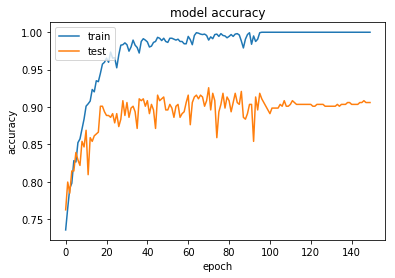

In [29]:
epochs = 150
save_as = 'fine_tuning_VGG19_2'
model = build_VGG19_fine_tuning_model()
history = train_model(model,'leishmaniasis',epochs,save_as=save_as)
# Export history
export_history(history, save_as,epochs)
# Plot accuracy
plt = get_plt(history)
plt.show()